In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *

### Annual Maxima Series (AMS) example

In [79]:
x = lognorm.rvs(0.49, size=int(1e7))

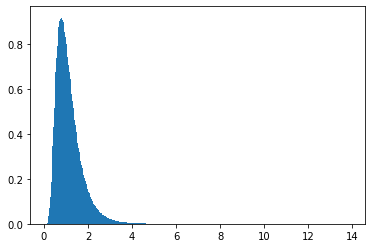

In [80]:
plt.hist(x, bins = 400, density = True)
plt.show()

In [81]:
n=10000
k = int(4000)
x = np.zeros(n*k)
max_arr = np.zeros(n)
for i in range(n):
    sample = lognorm.rvs(0.49, size = k)
    x[i*k:(i+1)*k] = sample
    max_arr[i] = np.max(sample)

Average of x: 1.127560958371855
Average of max(x1, ..., x4000): 5.951666171803753


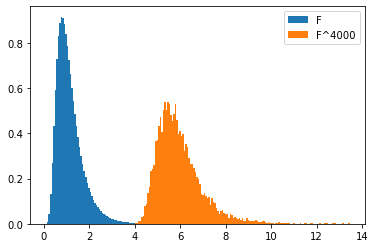

In [82]:
g = plt.hist(x, bins = 200, density = True, label = 'F')
plt.hist(max_arr, bins = g[1], density = True, label = 'F^{}'.format(k))
print('Average of x: {}\nAverage of max(x1, ..., x{}): {}'.format(np.mean(x), k, np.mean(max_arr)))
plt.legend()
plt.show()

### Peak-Over-Threshold (POT) analysis of net load

Let $Z \sim F_Z$ be system net load (load minus total available generation for randomly sampled system conditions).

We are interested in system conditions when $Z > 0$, which occur with very low probability (0.02%). Typical reliability standards are around LOLP of 2.4 hrs/year, indicating that $Pr(Z > 0) \approx 0.00027$. It isn't obvious whether 0 is a suitable threshold for POT analysis for net load data, but in theory these data should follow generalized Pareto distribution.

Can we use EVT to improve our estimates of tail probabilities? $\bar{F}(z) = Pr(Z > z) = Pr(Z > u)Pr(Z > z | Z > u) = \bar{F}(u)(1 + \xi \frac{z-u}{\sigma})^{-1/\xi}$ for $z \geq u$.

This is 70.21 years of data


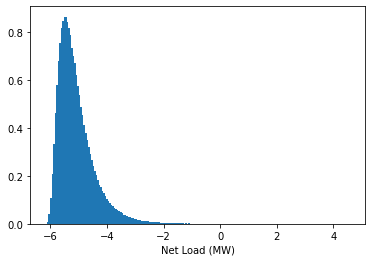

In [154]:
p_star = 2.4/8760 # Target LOLP
s = 0.53 # Parameter for log-normal distribution

n = int(6.15e5) 
print('This is {:.2f} years of data'.format(n/8760))

# Generate log-normal data

x = lognorm.rvs(s, size=n)
z = x - lognorm.ppf(1 - p_star, s)

g = plt.hist(z, bins = 200, density = True, label = 'F')
plt.xlabel('Net Load (MW)')
plt.show()

In [155]:
# Estimate LOLP directly from this data

p_star_hat = np.sum(z > 0)/n
print('p*: {}\np*^: {}'.format(p_star, p_star_hat))
print('Error: {}%'.format(100*(p_star - p_star_hat)/p_star))

p*: 0.000273972602739726
p*^: 0.00024390243902439024
Error: 10.975609756097555%


In [156]:
# Choose u and estimate Pr(Z > u) (p_u)

u = lognorm.ppf(1 - 0.0075, s) - lognorm.ppf(1 - p_star, s) # Choose u

p_u = 1 - lognorm.cdf(lognorm.ppf(1 - p_star, s) + u, s)
p_u_hat = np.sum(z > u)/n
print('p_u: {}\np_u^: {}'.format(p_u, p_u_hat))
print('Error: {}%'.format(100*(p_u - p_u_hat)/p_u))

p_u: 0.007499999999999951
p_u^: 0.007626016260162602
Error: -1.6802168021686856%


In [158]:
# Fitting xi, beta in generalized Pareto distribution to the tail z > u

# Fitting generalized Pareto distribution to the tail z > u
xi, _, sigma = genpareto.fit(z[z > u], floc = u)

def GPD(z, u, xi, sigma):
    return (1 + xi*((z - u)/sigma))**(-1/xi)

# Estimating p
p_star_hat_EVT = p_u_hat*GPD(0, u, xi, sigma)

print('p*: {}\np*^_EVT: {}'.format(p_star, p_star_hat_EVT))
print('Error: {}%'.format(100*(p_star - p_star_hat_EVT)/p_star))

p*: 0.000273972602739726
p*^_EVT: 0.00025238656267278576
Error: 7.878904624433193%


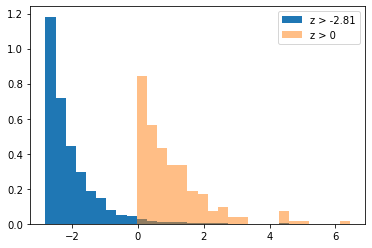

In [266]:
# Observe tail of distribution
g = plt.hist(z[z > u], bins = 30, density = True, label = 'z > {:.2f}'.format(u))
plt.hist(z[z > 0], bins = g[1], alpha = 0.5, density = True, label = 'z > 0')
plt.legend()
plt.show()

In [271]:
s = 0.53 # Parameter for log-normal distribution

p_star = 2.4/8760 # Target LOLP
loc = lognorm.ppf(1 - p_star, s) # 1 - p_star quantile


n = int(6.15e5) 
print('Using {:.2f} years of simulated data'.format(n/8760))

M = 500 # Number of trials

p_hat_arr = np.zeros(M)
p_hat_EVT_arr = np.zeros(M)

for i in range(M):
    
    x = lognorm.rvs(s, size=n) # Generate log-normal data
    z = x - loc # Shift so that Pr(Z > 0) = p* (target LOLP)
    
    p_star_hat = np.sum(z > 0)/n # Direct estimate of LOLP from data
    
    u = lognorm.ppf(1 - 0.015, s) - lognorm.ppf(1 - p_star, s) # Choose u
    p_u_hat = np.sum(z > u)/n # Estimate Pr(Z > u)
    xi, _, sigma = genpareto.fit(z[z > u], floc = u) # Fit xi, sigma to tail
    
    p_star_hat_EVT = p_u_hat*GPD(0, u, xi, sigma) # Estimate LOLP using EVT
    
    p_hat_arr[i] = p_star_hat
    p_hat_EVT_arr[i] = p_star_hat_EVT
    

Using 70.21 years of simulated data


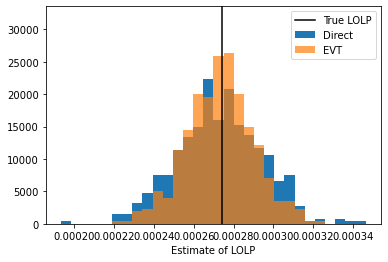

MAPE of Direct Method: 6.20%
MAPE of EVT Method: 4.82%


In [272]:
g = plt.hist(p_hat_arr, bins = 30, label = 'Direct', density = True)
plt.hist(p_hat_EVT_arr, bins = g[1], alpha = 0.7, label = 'EVT', density = True)

plt.plot([p_star, p_star], [0, 5*max(g[0])], 'k', label = 'True LOLP')
plt.axis([None, None, 0, 1.5*max(g[0])])
plt.legend()
plt.xlabel('Estimate of LOLP')
plt.show()

print('MAPE of Direct Method: {:.2f}%'.format(100* np.mean(np.abs(p_hat_arr - p_star)/p_star)))
print('MAPE of EVT Method: {:.2f}%'.format(100* np.mean(np.abs(p_hat_EVT_arr - p_star)/p_star)))

In [273]:
# EUE Estimation

s = 0.53 # Parameter for log-normal distribution

p_star = 2.4/8760 # Target LOLP
loc = lognorm.ppf(1 - p_star, s)

n = int(6.15e5) 
print('Using {:.2f} years of simulated data'.format(n/8760))

M = 500 # Number of trials

EUE_star = lognorm.expect(args = (s,), loc = -loc, lb = 0, conditional = True)
EUE_arr = np.zeros(M)
EUE_EVT_arr = np.zeros(M)

for i in range(M):
    
    x = lognorm.rvs(s, size=n) # Generate log-normal data
    z = x - loc # Shift so that Pr(Z > 0) = p* (target LOLP)
    
    EUE_hat = np.mean(z[z > 0]) # Direct estimate of EUE from data
    
    u = lognorm.ppf(1 - 0.015, s) - lognorm.ppf(1 - p_star, s) # Choose u
    xi, _, sigma = genpareto.fit(z[z > u], floc = u) # Fit xi, sigma to tail
    EUE_hat_EVT = genpareto.expect(args = (xi,), loc = u, scale = sigma, lb = 0, conditional = True) # Estimate EUE with GPD
    
    EUE_arr[i] = EUE_hat
    EUE_EVT_arr[i] = EUE_hat_EVT
    

Using 70.21 years of simulated data


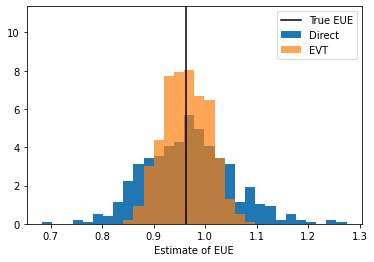

MAPE of Direct Method: 6.20%
MAPE of EVT Method: 4.82%


In [274]:
g = plt.hist(EUE_arr, bins = 30, label = 'Direct', density = True)
plt.hist(EUE_EVT_arr, bins = g[1], alpha = 0.7, label = 'EVT', density = True)

plt.plot([EUE_star, EUE_star], [0, 5*max(g[0])], 'k', label = 'True EUE')
plt.axis([None, None, 0, 2.0*max(g[0])])
plt.legend()
plt.xlabel('Estimate of EUE')
plt.show()

print('MAPE of Direct Method: {:.2f}%'.format(100* np.mean(np.abs(p_hat_arr - p_star)/p_star)))
print('MAPE of EVT Method: {:.2f}%'.format(100* np.mean(np.abs(p_hat_EVT_arr - p_star)/p_star)))

